In [150]:
import torch 
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [151]:
df = pd.read_csv("train.csv")
df.isnull().sum()


StudentID              0
Age                    0
Gender                 0
Ethnicity              0
ParentalEducation    142
StudyTimeWeekly        0
Absences               0
Tutoring               0
ParentalSupport      132
Extracurricular        0
Sports                 0
Music                  0
Volunteering           0
GPA                    0
dtype: int64

### numeric fields 
- some of the fields like ParentalEducation , ParentalSupport should be in numeric form 


In [152]:
# replacing the missing value with the most frequesnt ones in the dataset

education_mode = df['ParentalEducation'].mode()[0]
support_mode = df['ParentalSupport'].mode()[0]

df['ParentalEducation'].fillna(education_mode, inplace=True)
df['ParentalSupport'].fillna(support_mode, inplace=True)

print(f"\nReplaced ParentalEducation nulls with: {education_mode}")
print(f"Replaced ParentalSupport nulls with: {support_mode}")
df.isnull().sum()


Replaced ParentalEducation nulls with: Some College
Replaced ParentalSupport nulls with: Moderate


/tmp/ipykernel_7688/1684217187.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ParentalEducation'].fillna(education_mode, inplace=True)
/tmp/ipykernel_7688/1684217187.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=

StudentID            0
Age                  0
Gender               0
Ethnicity            0
ParentalEducation    0
StudyTimeWeekly      0
Absences             0
Tutoring             0
ParentalSupport      0
Extracurricular      0
Sports               0
Music                0
Volunteering         0
GPA                  0
dtype: int64

In [153]:
# categorial to some numeric value

df['ParentalEducation'] = pd.factorize(df['ParentalEducation'])[0]
df['ParentalSupport'] = pd.factorize(df['ParentalSupport'])[0]
df['Ethnicity'] = pd.factorize(df['Ethnicity'])[0]

In [154]:
# diffrentiat ethe values and stuff
X = df.drop(['StudentID', 'GPA'], axis=1)
y = df['GPA']

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print("\nTraining set shapes:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")

print("\nTesting set shapes:")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")



Training set shapes:
X_train: (1224, 12)
y_train: (1224,)

Testing set shapes:
X_test: (306, 12)
y_test: (306,)


In [156]:
# vonersion to PyTorch tensors 
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [157]:
from torch.utils.data import DataLoader, TensorDataset
#Create data loaders

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [158]:
class ImprovedNN(nn.Module):
    def __init__(self, input_dim):
        super(ImprovedNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.dropout(x)
        x = self.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [ ]:
input_dim = X_train_tensor.shape[1]
model = ImprovedNN(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 1000
patience = 1000
best_loss = float('inf')
early_stop_counter = 0
model.train()

ImprovedNN(
  (layer1): Linear(in_features=12, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=32, bias=True)
  (layer4): Linear(in_features=32, out_features=1, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [ ]:
costs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        costs.append(loss.item())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    
    if avg_loss < best_loss:
        best_loss = avg_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    if early_stop_counter >= patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if (epoch+1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

Epoch [10/1000], Loss: 0.2243
Epoch [20/1000], Loss: 0.1600
Epoch [30/1000], Loss: 0.1430
Epoch [40/1000], Loss: 0.1221
Epoch [50/1000], Loss: 0.1002
Epoch [60/1000], Loss: 0.0961
Epoch [70/1000], Loss: 0.0865
Epoch [80/1000], Loss: 0.0898
Epoch [90/1000], Loss: 0.0874
Epoch [100/1000], Loss: 0.0830
Epoch [110/1000], Loss: 0.0781
Epoch [120/1000], Loss: 0.0732
Epoch [130/1000], Loss: 0.0722
Epoch [140/1000], Loss: 0.0703
Epoch [150/1000], Loss: 0.0704
Epoch [160/1000], Loss: 0.0699
Early stopping at epoch 166


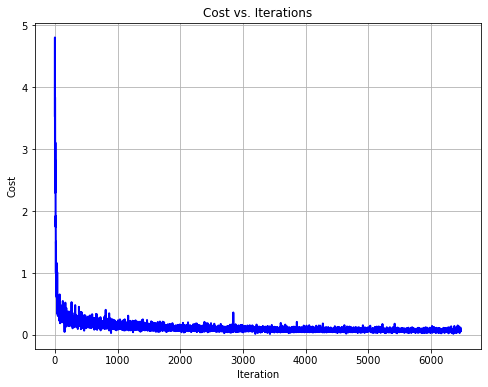

In [161]:
# ploting the cost-epoch
iterations = np.arange(0, len(costs))
with torch.no_grad():
    plt.figure(figsize=(8, 6))
    plt.plot(iterations, costs, 'b-', linewidth=2)
    plt.xlabel("Iteration")
    plt.ylabel("Cost")
    plt.title("Cost vs. Iterations")
    plt.grid(True)
    plt.show()

In [162]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")

Test Loss: 0.2075


In [163]:
test_df = pd.read_csv('test.csv')  # Ensure this is the correct path to your test CSV file

In [164]:
print("Missing values in the test dataset before replacement:")
print(test_df.isnull().sum())

Missing values in the test dataset before replacement:
StudentID             0
Age                   0
Gender                0
Ethnicity             0
ParentalEducation    40
StudyTimeWeekly       0
Absences              0
Tutoring              0
ParentalSupport      30
Extracurricular       0
Sports                0
Music                 0
Volunteering          0
GPA                   0
dtype: int64


In [165]:
test_df['ParentalEducation'].fillna(education_mode, inplace=True)
test_df['ParentalSupport'].fillna(support_mode, inplace=True)

/tmp/ipykernel_7688/1716585061.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['ParentalEducation'].fillna(education_mode, inplace=True)
/tmp/ipykernel_7688/1716585061.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inp

In [166]:
test_df['ParentalEducation'] = pd.factorize(test_df['ParentalEducation'])[0]
test_df['ParentalSupport'] = pd.factorize(test_df['ParentalSupport'])[0]
test_df['Ethnicity'] = pd.factorize(test_df['Ethnicity'])[0]

In [167]:
X_test_new = test_df.drop(['StudentID', 'GPA'], axis=1)
y_test_new = test_df['GPA']

In [168]:
X_test_new_scaled = scaler.transform(X_test_new)
X_test_new_scaled = pd.DataFrame(X_test_new_scaled, columns=X_test_new.columns)

# Convert data to PyTorch tensors
X_test_new_tensor = torch.tensor(X_test_new_scaled.values, dtype=torch.float32)
y_test_new_tensor = torch.tensor(y_test_new.values, dtype=torch.float32).view(-1, 1)

In [169]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test_new_tensor)

In [170]:
from sklearn.metrics import r2_score

r2 = r2_score(y_test_new_tensor.numpy(), y_test_pred.numpy())
print(f"R² score on the test data: {r2:.4f}")

R² score on the test data: 0.7773
